$\newcommand{\similarity}{\text{similarity}}$
$\newcommand{\update}{{\small\text{UPDATE}}}$
$\newcommand{\aggregate}{{\small\text{AGGREGATE}}}$



**After this laboratory you should be able to**
- Explain the GNN framework
- Understand where neural networks come in.
- Understand the aggregate and update functions

## Resources

**Exaplanations**
- [Video explanation](https://www.youtube.com/watch?v=2KRAOZIULzw&t=1s) with [blog post](https://blog.zakjost.com/post/gcn_citeseer/)
- [Video explanation 2](https://www.youtube.com/watch?v=me3UsMm9QEs)
- [Video tutorial 3](https://www.youtube.com/watch?v=fOctJB4kVlM&t)
- [Introductory Article](https://distill.pub/2021/gnn-intro/)

**Relevant papers**
- GraphSage paper [Inductive Representation Learning on Large Graphs](https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf),  [arvix link](https://arxiv.org/abs/1706.02216)
- GCN paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907)
- GAT paper [Graph Attention Networks](https://arxiv.org/abs/1710.10903)

# GNN Framework

## Differences from simple datatypes

**CNN**

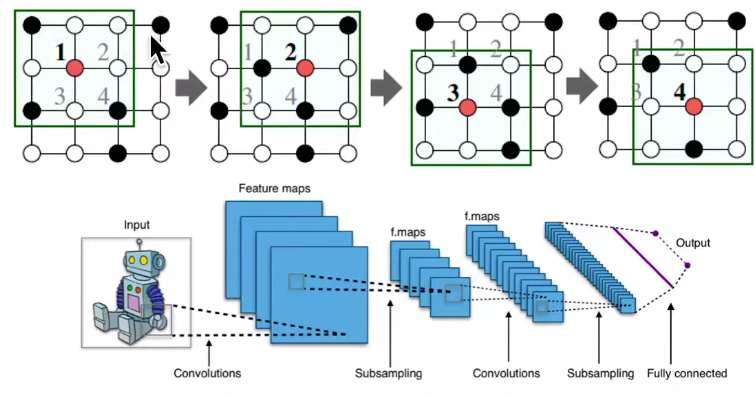

Let  
$G$ be a graph with $n$ nodes in the node set $V$ and $m$ edges.  
For a node $v \in V$ we denote $N(v)$ the size of the neighbourhood ov $v$.  
$X \in \mathbb R^{m \times n}$ is a matrix of **node features**. If there is no feature we can use one-hot encode the node or put a vector of 1s

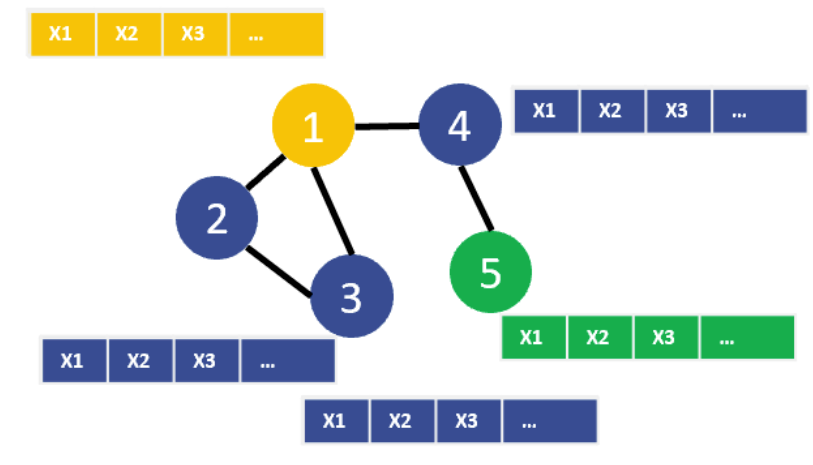

Key differences between simple datatypes (like images) and graph
1. Non-euclidean structure
    - There is no fixed notion of locality (there is no top left or bottom right)
    - If we are to replicate image convolutions there is no concept of "sliding window"
3. The network must be **permutation-invariant** (Nodes have no ordering, graphs can be isomorphic, if we pass nodes in a different order we should get the same results). 
    - Usually neural networks care about ordering
4. The GNN must be able to work with graph of different sizes and shapes. 
    - Most neural networks have fixed input size. We cannot "resize a graph" like we do with images. Therefore our framework must be flexible

*Thought experiment*  
Think about why using the adjacency matrix as an input (flatten and feed into a MLP) is **not** a good idea 
    


## Message passing 

**Task**: Train a model that can compute relevant node embeddings for the given ML task

*Intuition:* Similar to convolutions, we want to capture neighbourhoods of one node. At each iteration we want to get some information from the neighbourhood. After some iterations have passed we want our **node embedding** to contain information from multiple parts of our graph


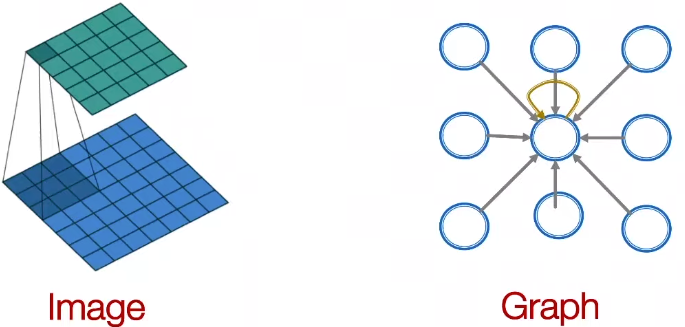

**Main formula**  
For each node $u \in V$ let  $h_u^{(k)}$ be a **hidden embedding** computed at step $k$. The update step can be expressed as follows:

$$
\begin{align}
h_u^{(k+1)} &= \update^{(k)}\left(h_u^{(k)}, \aggregate^{(k)} \left(\right\{h_v^{(k)}, \forall v \in N(u)\left\}\right)\right) \\
&= \update^{(k)}\left(h_u^{(k)}, m^{(k)}_{N(u)})\right)
\end{align}
$$
Where $\update$ and $\aggregate$ are arbitrary differentiable functions and $m_N(u)$ is the aggregated message from $u$'s neighbourhood $N(u)$.

**Algorithm**
1. At step $k = 0$ the initial embeddings are the input features for all nodes $h_u^{0} = x_u \ \forall u \in V$
2. At each step $k$ the $\aggregate$ function takes as input the **set of embeddings** of the nodes in $u$’s neighborhood $N(u)$ and generates a message $m^{(k)}_N(u)$
based on this aggregated neighborhood information. The $\update$ function update then combines the message $m_N(u)$ with the previous embedding $h^{(k)}_u$

After some steps the information will propagate through the network and the embeddings should contain information from neighbours (Notice the mixed embeddings)

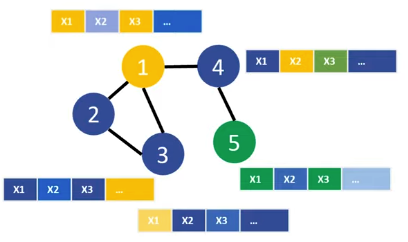

**What type of information propagates?**
- **Structural information** about the graph -- after $k$ iterations a the embedding of a node might encode the degree of his neighbours. Example: in molecular graphs we can use degree information to infer atom types and *structural motifs* (like benzene rings)
- **Feature based** -- after $k$ iterations a the embedding of a node contains information about the neighbours features

### Computation graph representation
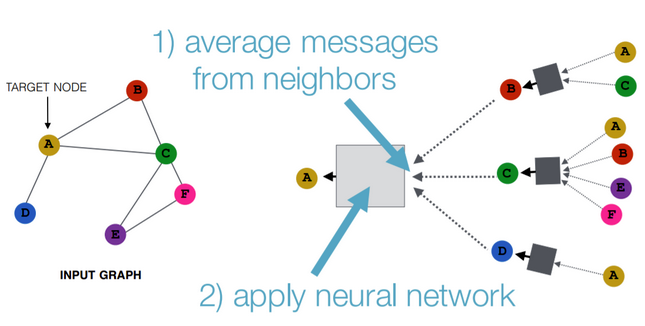

Node neighbourhood defines the **node computation graph**. We can unfold the graph a few hops to generate a computation graph **per node**.

Using this representation GNNs can be thought as a 2-step process
1. Find the node computation graph
2. Propagate information over the computation graph

**Remark**
- The number of layers in the neural network represents the number of hops we make in the graph. The first layer gets information from node features, the $k$th layer gets information from nodes $k$ steps away

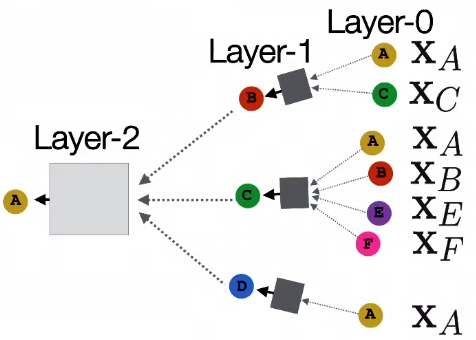

# The NN in GNN

**Message passing**:
$$ h_u^{(k)} = \sigma\left( W_{\text{self}}^{(k)}h_u^{(k-1)} + W_{\text{neigh}}^{(k)} \sum_{v \in N(u)}h_v^{(k-1)} + b^{(k)} \right)$$
Where
- $W_{\text{self}}^{(k)}, W_{\text{neigh}}^{(k)} \in R^{d^{(k)} \times d^{(k-1)}}$ are the **trainable parameters** (weights)
- $b^{(k)} \in R^{d^{(k)}}$ is the bias term
- $\sigma$ is a nonlinearity function (ReLU, tanh, sigmoid etc)

**Important remark** - The weight matrices $W$ are shared between different nodes -> All nodes use the $W$ matrices

If we use the aggregate-update framework:

$$m_{N(u)} = \aggregate \left(\left\{h_v, \forall v \in N(u)\right\}\right) = \sum_{v \in N(u)}h_v$$

$$\update\left(h_u, m_{N(u)}\right) = \sigma\left( W_{\text{self}} h_u + W_{\text{neigh}} m_{N(u)}\right)$$

**Matrix form**  
Let $A$ be the adjacency matrix of the graph. Let $H$ be the embedding matrix (each row is a node embedding)

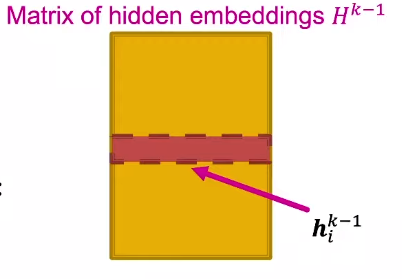

We can write the $\aggregate$ function as follows:
$$H^{(k)} = AH^{(k-1)}$$

**The self loop trick**  
Notice that the update step just adds information from the current node embedding. We can combine the steps if we add a *self-loop*. After we add the self-loop the $\aggregate$ function will take into consideration the current node embedding too.  
Now we don't need an explicit update function, we can do the update step through the aggretation method. In matrix form:

$$H^{(k+1)} = \sigma\left(\underbrace{(A + I)}_{\tilde{A}}H^{(k-1)}W^{(k)}\right)$$

**Remark** Since $A$ is usually sparse we can use efficient sparse matrix multiplication to train the models. This form can be used only if the $\aggregate$ function can be expressed through matrices

**When to use this?** The self loop trick is not universally applicable. In some tasks we might want to process the current node information differently from the neighbours information (Ex: We have a NN trained for the self embedding and another one for the neighbour embedding)

## Aggregate function

**Properties**
1. **Permutation invariant** - The order in which we pass the node embeddings in the function doesn't change the result

### Sum-like functions

**Normalization**  
**Average / mean** -- One issue with the sum is that it's highly insensitive to node degrees. Therefore we might want to normalize
$$m_{N(u)} = \dfrac {\sum_{v \in N(u)}h_v} {|N(u)|}$$
There are also different normalization factors that are successful: **Symmetric normalization**
$$m_{N(u)} = \dfrac {\sum_{v \in N(u)}h_v} {\sqrt{|N(u)|\cdot |N(v)|}}$$

**Matrix form**  
Let $D$ be the degree matrix with $D_{ii} = \deg(i) = |N(i)|$. Since $D$ is diagonal we have $D^n$ with $D_{ii}^n = \deg(i)^n$ and $D_{ii}^{-1} = \dfrac 1 {\deg(i)^n}$. Let $\tilde{A} = A + I$ and $\tilde{D}$ its degree matrix.  
Then we can write the $\update$ normalizing equation as follows:
$$H^{(k)} = \sigma \left( \tilde{D}^{-1} \tilde{A} H^{(k-1)} W^{(k)}\right)$$
Or symmetric normalization:
$$H^{(k)} = \sigma \left( \tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(k-1)} W^{(k)} \right)$$

*Intuition for matrix forms*: https://math.stackexchange.com/questions/3035968/interpretation-of-symmetric-normalised-graph-adjacency-matrix

Pros and cons of normalization
- $+$ Stable
- $-$ Loss of information -- Information about degrees is lost (learned embeddings cannot distinguish between nodes of different degrees)

**When to normalize?** When node features are more important / useful than structural information, or when there is a very wide range of node degrees that can lead to
instabilities during optimization.

There are other aggregation functions used such as pooling operators, permutation invariant set approximators or some recurrent NN like LSTM (In the LSTM case you want to permute the orders for more variations)

## Update function

**The over-smoothing problem**  
After several message passing iterations the embeddings can become very similar one to another (We get information from too many nodes, see picture). If we are also using self-loops the current node embedding is for sure lost! This is a problem because we cannot build deeper GNN models -> No long term dependencies in the graph.

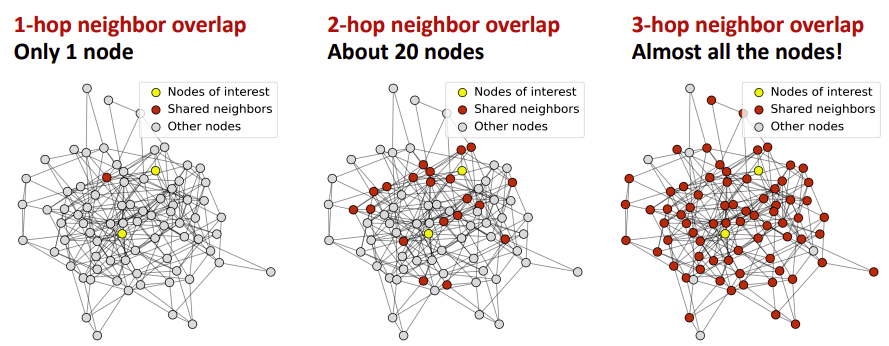

This issue can be formalized by defining the influence of each nodes input feature $h_u^{(0)} = x_u$ on the final layer embedding of all nodes in the graph $h_v^{(k)} \ \forall v \in V$.  
An important theorem states that if we use self-loops the influence of $u$ on $v$ after $k$ iterations is proportional to the probability of visinting node $v$ of a length $k$ random walk starting from $u$

We will present some solutions.

### Skip connections
A simple idea is to use the old embedding somehow after applying the $\update$ function.

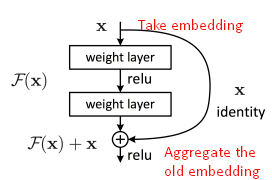

**Concatenation**
$$\update_{\text{concat}}\left(h_u, m_{N(u)}\right) = \left[ \update_{\text{base}}\left(h_u, m_{N(u))}\right) \ | \ h_u \right]$$

**Interpolation**
$$\update_{\text{interpolate}}\left (h_u, m_{N(u)} \right) = \alpha_1 \cdot \update_{\text{base}}\left( h_u, m_{N(u)} \right) \ + \alpha_2 \cdot h_u $$
Where $\alpha_1, \alpha_2 \in [0, 1]^d$ and $\alpha_2 = 1 - \alpha_1$

### Recurrent neural networks
Since recurrent neural networks take into consideration history they can be used as an update function to alleviate the over-smoothing problem
$$h_u^{k} = \update\left(h_u, m_{N(u)}\right) = \text{RNN}(h_u, m_{N(u))})$$

### Jumping knolwedge connections

Usually we used the output of the GNN (last layer embedding) as a node representation. However we are not forced to do this. We can define the node representation $z_u$ as a combinations of messages from different steps:
$$z_u = f_{jk}\left(h_u^{(0)} \ | \ h_u^{(1)} \ | ... \ | \ h_u^{(k)}\right)$$
where $f_{jk}$ is a differentiable function. 

### Add layers in smart places

There are places where you can add layers to increase expresiveness. Let's explore 2 options

**Add within the GNN layer**  
In the GNN framework the $\update$ and $\aggregate$ functions used only 1 layer to transform the embeddings ($WH$). We are not forced to do this, we can use deeper models $\text{MLP}(H)$

**Add layers that do not pass messages**  
Not every layer must pass messages. We can add layers that preprocess our features and postprocess the results. Example: If our node features are images we might want to apply some 2d convolutions on them to compute new features before applying the GNN layer.

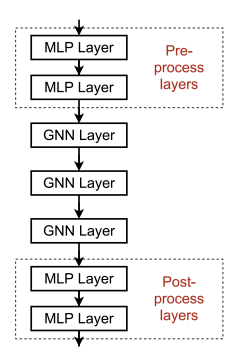


# Code

In [8]:
import networkx as nx
import numpy as np
import scipy
import scipy.stats as st
import matplotlib.pyplot as plt
import itertools
import os, sys
import random
import time

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_auc_score



In [9]:
parent_dir = os.path.abspath(os.path.join('..'))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)
    
#from utils.utils import average_clustering, average_degree, connectivity_perc, giant_component, communities_to_dict, dict_to_communities, load_graph
from utils.pyg_utils import print_dataset, print_data

## Load and inspect data

In [10]:
import torch
import torch_geometric
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.data import Data, DataLoader
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

import torch_geometric.transforms as geom_T

from torch_geometric.datasets import Planetoid



In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device = }")

device = 'cuda'


In [12]:
dataset = Planetoid(root = os.path.join('..', 'data', 'tmp', 'Cora'), name = 'Cora')
data = dataset[0]

print_dataset(dataset)
print()
print_data(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [13]:
data.to(device)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

## Helper libs

### torch_sparse
- https://github.com/rusty1s/pytorch_sparse

Library for optimized matrix operations. This avoids the hazzle of always going through `torch.sparse_coo_tensor`

In [7]:
import torch_sparse

In [8]:
x = torch.tensor([
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 0]
]).to_sparse()
x

tensor(indices=tensor([[0, 0, 1, 2],
                       [1, 2, 0, 0]]),
       values=tensor([1, 1, 1, 1]),
       size=(3, 3), nnz=4, layout=torch.sparse_coo)

In [9]:
index, value = x.indices(), x.values()

In [10]:
x_st = torch_sparse.SparseTensor(row = index[0], col = index[0], value =value)
x_st

SparseTensor(row=tensor([0, 0, 1, 2]),
             col=tensor([0, 0, 1, 2]),
             val=tensor([1, 1, 1, 1]),
             size=(3, 3), nnz=4, density=44.44%)

In [11]:
x_st.matmul(x_st)

SparseTensor(row=tensor([0, 1, 2]),
             col=tensor([0, 1, 2]),
             val=tensor([4, 1, 1]),
             size=(3, 3), nnz=3, density=33.33%)

### torch_scatter
- https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter

In [12]:
from torch_scatter import scatter

In [13]:
src = torch.randint(low = 0, high = 10, size = (6, ))
index = torch.tensor([0, 1, 0, 1, 2, 1])

out = scatter(src, index, dim=0, reduce="sum")

print(src)
print(index)
print(out)

tensor([8, 3, 9, 4, 1, 6])
tensor([0, 1, 0, 1, 2, 1])
tensor([17, 13,  1])


## Graph convolutional layer

The `MessagePassing` class - https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

Methods:
- `MessagePassing(aggr="add", flow="source_to_target", node_dim=-2)` -- Defines aggregation scheme and the flow direction of message passing. `node_dim` indicates along which axis to propagate
- `MessagePassing.propagate(edge_index, size, **kwargs)` -- Initial call to start propagating messages
- `MessagePassing.message(...)` -- Constructs messages to node $i$. Can take any argument which was passed to `propagate()`. In addition, tensors passed to `propagate()` can be mapped to the respective nodes $i$ and $j$ by appending `_i` or `_j` to the variable name. ($i$ is the central node and $j$ are the neighbours) 
- `MessagePassing.update(...)` -- Updates node embeddings. Takes in the output of aggregation as first argument and any argument which was initially passed to `propagate()`

We shall implement hte [GCN layer](https://arxiv.org/abs/1609.02907) defined as
$$h_u^{k} = \sum_{v \in N(u) \cup \{u\}} \dfrac 1 {\sqrt{|N(u)|\cdot |N(v)|}} \cdot \left(Wh_v^{(k-1)}\right)$$

In [58]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


In [15]:
layer = torch.nn.Linear(2, 4)
layer

Linear(in_features=2, out_features=4, bias=True)

In [16]:
layer.weight

Parameter containing:
tensor([[ 5.5279e-01,  1.4454e-04],
        [ 4.6659e-01, -3.0514e-01],
        [-1.1925e-01,  1.3718e-01],
        [-4.2673e-02, -2.2651e-01]], requires_grad=True)

In [17]:
print(data.edge_index.shape)
print(add_self_loops(data.edge_index)[0].shape)

torch.Size([2, 10556])
torch.Size([2, 13264])


In [59]:
class GCNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, device):
        # 5. Define aggregation function
        super(GCNLayer, self).__init__(aggr = 'add') 
        self.lin = torch.nn.Linear(in_channels, out_channels) # Linear layer for W
        self.device = device
        self.to(device)
        
        
    def forward(self, x, edge_index):
        # 1. Add self loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        # 2. Perform the linear transformation with W
        x = self.lin(x)
        # 3. Normalize
        row, col = edge_index
        D = degree(col, num_nodes=x.size(0), dtype = x.dtype)
        D_ = D.pow(-.5) # Obviously this produces `inf` on nodes that have no neighbours. 
        D_[D_ == float('inf')] = 0
        norm = D_[row] * D[col]
        
        # 4. Propagate. We pass the computed normalization
        return self.propagate(edge_index, x=x, norm=norm)
        
    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]
        
        # 4. Normalize node features.
        return norm.view(-1, 1) * x_j




In [19]:
layer = GCNLayer(data.num_features, 16, device)

In [20]:
emb = layer(data.x, data.edge_index)

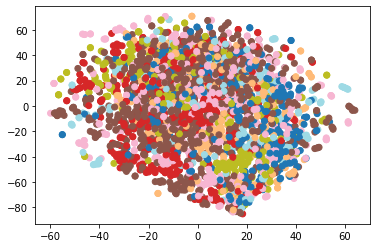

In [21]:
# Try to pca the embeddings
cora_color = data.y.cpu()
#plt.scatter(*PCA(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
plt.scatter(*TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T, c = cora_color, cmap = plt.cm.tab20)
#plt.scatter(*UMAP(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)

plt.show()

## Graph convolution model

In [22]:
from torch_geometric.nn import GCNConv

In [60]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, device, return_embeds = False):
        
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.device = device
        self.return_embeds = return_embeds
        
        # List of GCN conv layers layers
        self.convs = torch.nn.ModuleList([GCNLayer(in_channels=input_dim, out_channels=hidden_dim, device = device)])
        for i in range(num_layers - 1):
            self.convs.append(GCNLayer(in_channels=hidden_dim, out_channels=hidden_dim, device = device))
        
        # Post processing
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        self.to(device)
        
    def forward(self, x, edge_index):
        for i, layer in enumerate(self.convs):
            # Last layer
            if i == self.num_layers - 1:
                x = layer(x, edge_index)
                if self.return_embeds:
                    return x
                x = self.classifier(x)
                out = self.softmax(x)
            else:
                x = layer(x, edge_index)
                x = F.relu(x)
                
        return out
                
        

In [61]:
# Initialize model and parameters

model = GCN(data.num_features, 256, dataset.num_classes, 2, device = device)

optimizer = torch.optim.Adam(model.parameters(), lr = .001)
loss_function = F.nll_loss#torch.nn.CrossEntropyLoss()  # Define loss function


In [62]:
model

GCN(
  (convs): ModuleList(
    (0): GCNLayer(
      (lin): Linear(in_features=1433, out_features=256, bias=True)
    )
    (1): GCNLayer(
      (lin): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (classifier): Linear(in_features=256, out_features=7, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [63]:
# Training and evaluation functions
def train_model(model, data, train_idx, optimizer, loss_function):
    
    # Don't forget these!
    model.train()
    optimizer.zero_grad()
    
    # Get predictions, compute loss and backprop
    out = model(data.x, data.edge_index)
    loss = loss_function(out[train_idx], data.y[train_idx])
    acc = torch.sum(data.y[train_idx] == torch.argmax(out[train_idx], dim = 1)) / len(data.y[train_idx])
    
    loss.backward()
    optimizer.step()
    
    return loss.item(), acc.item()

def eval_model(model, data, val_idx, loss_function):
    # We don't need the gradients for evaluation!
    with torch.no_grad():
        model.eval()
        out = model(data.x, data.edge_index)
        loss = loss_function(out[val_idx], data.y[val_idx])
        acc = torch.sum(data.y[val_idx] == torch.argmax(out[val_idx], dim = 1)) / len(data.y[val_idx])

    return loss.item(), acc.item()

In [64]:
epochs = 101
for epoch in range(epochs):
    loss_train, acc_train = train_model(model, data, data.train_mask, optimizer, loss_function)
    loss_val, acc_val = eval_model(model, data, data.val_mask, loss_function)
    
    if epoch % 20 == 0:
        print(f"{epoch = } | {loss_train=: .2f} {acc_train=: .2f} \t {loss_val=: .2f} {acc_val=: .2f}")

epoch = 0 | loss_train= 9.42 acc_train= 0.14 	 loss_val= 6.73 acc_val= 0.22
epoch = 20 | loss_train= 0.90 acc_train= 0.95 	 loss_val= 3.42 acc_val= 0.63
epoch = 40 | loss_train= 0.16 acc_train= 0.99 	 loss_val= 3.22 acc_val= 0.67
epoch = 60 | loss_train= 0.08 acc_train= 1.00 	 loss_val= 3.93 acc_val= 0.70
epoch = 80 | loss_train= 0.04 acc_train= 1.00 	 loss_val= 4.29 acc_val= 0.70
epoch = 100 | loss_train= 0.02 acc_train= 1.00 	 loss_val= 4.77 acc_val= 0.71


In [65]:
model.eval()
out = model(data.x, data.edge_index)
print((torch.sum(data.y[data.test_mask] == torch.argmax(out[data.test_mask], dim = 1)) / len(data.y[data.test_mask])).item())

0.7070000171661377


In [66]:
# Let's look at some embeddings
model.return_embeds = True
model.eval()
emb = model(data.x, data.edge_index)

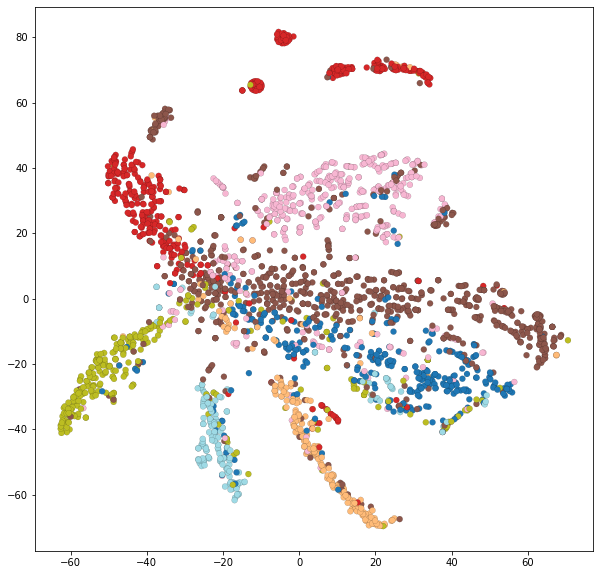

In [67]:
cora_color = data.y.cpu()
plt.figure(figsize = (10, 10))
plt.scatter(*TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T, c = cora_color, cmap = plt.cm.tab20, edgecolors='black', linewidths = .1)

plt.show()

# Neighbourhood attention 
- GAT paper https://arxiv.org/pdf/1710.10903.pdf
- https://github.com/gordicaleksa/pytorch-GAT#what-are-gnns
- [Explainer](https://www.youtube.com/watch?v=A-yKQamf2Fc&t)

When we presented $\aggregate$ functions we treated every neighbour the same. For example when we summed them everyone had the same importance in the sum. But a strategy to improve the aggregation layer is to treat neighbours differently making one neighbour more important than another. This concept is called assigning **attention weights** to neighbours.

$$m_{N(u)} = \sum_{v \in N(u)}\alpha_{uv}h_v$$

Where $\alpha_{uv}$ is the attention weight  
In the previous cases $\alpha_{uv} = \dfrac 1 {|N(u)|}$ was the same $\Rightarrow$ all neighbours are equally important.

We want the neural network to devote more computing power (attention) on one small but important part of data. The attention weight $\alpha_{uv}$ depends on the context and is learned through training.

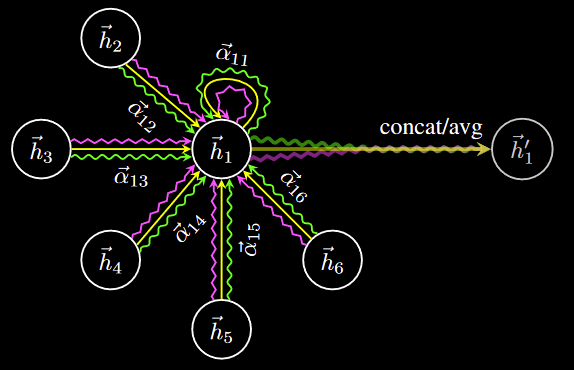

## Attention mechanism

Let $a$ be our attention function. Then for a node u and each of his neighbours $v \in N(u)$ we want to compute the attention coefficient: 
$$e_{uv} = a\left(W^{(k)}h_u^{(k-1)},\ W^{(k)} h_v^{(k-1)}\right)$$

After computing the coefficients of the neighbours of $u$ we want to normalize them to compute the attention weights $\alpha_{vu}$. Let's apply the softmax function:

$$\alpha_{uv} = \text{softmax}(e_{uv}) = \dfrac {\exp(e_{uv})} {\sum_{k \in N(u)} \exp(e_{uk})}$$

Then our new way to compute the node embeddings becomes:
$$h_u^{(k)} = \left( \sum_{v \in N(u)} \alpha_{uv} W^{(k)} h_u^{(k-1)}\right)$$

**OK, but how does the attention mechanism $a$ look like?**

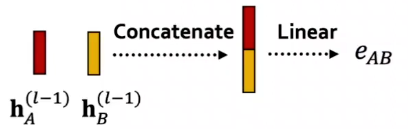

The basic approach is to concatenate the embeddings and pass them through a linear layer
$$e_{uv} = \text{Lin}\left(W^{(k)}h_u^{(k-1)} \ |  \ W^{(k)}h_u^{(k-1)}\right)$$

We can use other approaches such as averaging or pooling the embeddings before passing them.

In [68]:
from torch_geometric.nn import GATConv

In [69]:
#?GATConv

In [100]:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, device, return_embeds = False):
        
        super(GAT, self).__init__()
        self.num_layers = num_layers
        self.device = device
        self.return_embeds = return_embeds
        
        # List of GCN conv layers layers
        self.convs = torch.nn.ModuleList([GATConv(in_channels=input_dim, out_channels=hidden_dim, dropout=.2, concat=False)])
        for i in range(num_layers - 1):
            self.convs.append(GATConv(in_channels=hidden_dim, out_channels=hidden_dim, dropout=.5, concat=False))
        
        # Post processing
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        self.to(device)
        
    def forward(self, x, edge_index):
        for i, layer in enumerate(self.convs):
            # Last layer
            if i == self.num_layers - 1:
                x = layer(x, edge_index)
                if self.return_embeds:
                    return x
                x = self.classifier(x)
                out = self.softmax(x)
            else:
                x = layer(x, edge_index)
                x = F.relu(x)
                
        return out
                
        

In [108]:
# Initialize model and parameters

model = GAT(data.num_features, 128, dataset.num_classes, 2, device = device)

optimizer = torch.optim.Adam(model.parameters(), lr = .001)
loss_function = F.nll_loss#torch.nn.CrossEntropyLoss()  # Define loss function


In [109]:
epochs = 101
for epoch in range(epochs):
    loss_train, acc_train = train_model(model, data, data.train_mask, optimizer, loss_function)
    loss_val, acc_val = eval_model(model, data, data.val_mask, loss_function)
    
    if epoch % 10 == 0:
        print(f"{epoch = } | {loss_train=: .2f} {acc_train=: .2f} \t {loss_val=: .2f} {acc_val=: .2f}")

epoch = 0 | loss_train= 1.95 acc_train= 0.11 	 loss_val= 1.94 acc_val= 0.12
epoch = 10 | loss_train= 1.67 acc_train= 0.86 	 loss_val= 1.79 acc_val= 0.67
epoch = 20 | loss_train= 1.14 acc_train= 0.90 	 loss_val= 1.44 acc_val= 0.75
epoch = 30 | loss_train= 0.61 acc_train= 0.86 	 loss_val= 0.97 acc_val= 0.77
epoch = 40 | loss_train= 0.53 acc_train= 0.83 	 loss_val= 0.79 acc_val= 0.78
epoch = 50 | loss_train= 0.24 acc_train= 0.94 	 loss_val= 0.76 acc_val= 0.77
epoch = 60 | loss_train= 0.30 acc_train= 0.91 	 loss_val= 0.79 acc_val= 0.77
epoch = 70 | loss_train= 0.20 acc_train= 0.96 	 loss_val= 0.83 acc_val= 0.76
epoch = 80 | loss_train= 0.17 acc_train= 0.95 	 loss_val= 0.83 acc_val= 0.77
epoch = 90 | loss_train= 0.12 acc_train= 0.96 	 loss_val= 0.82 acc_val= 0.78
epoch = 100 | loss_train= 0.21 acc_train= 0.92 	 loss_val= 0.87 acc_val= 0.78


In [110]:
model.eval()
out = model(data.x, data.edge_index)
print((torch.sum(data.y[data.test_mask] == torch.argmax(out[data.test_mask], dim = 1)) / len(data.y[data.test_mask])).item())

0.8030000329017639


In [111]:
# Let's look at some embeddings
model.return_embeds = True
model.eval()
emb = model(data.x, data.edge_index)

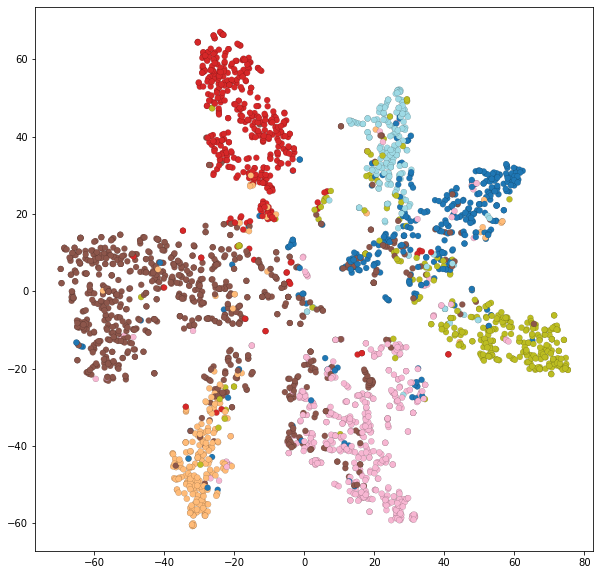

In [112]:
cora_color = data.y.cpu()
plt.figure(figsize = (10, 10))
plt.scatter(*TSNE(n_components=2).fit_transform(emb.cpu().detach().numpy()).T, c = cora_color, cmap = plt.cm.tab20, edgecolors='black', linewidths = .1)

plt.show()